In [1]:
%%html
<style type="text/css">
input.good:checked + label {color: green}
input.bad:checked + label {color: red}
input.good:checked + label::after {color: green; content: ' Õige vastus!'}
input.bad:checked + label::after {color: red; content: ' Vale vastus!'}
</style>

# Mittelineaarse ostsillaatori simulatsioon

See tööleht näitab, kuidas saab simuleerida mittelineaarse elektroonilise ostsillaatori võnkumist. Ostsillaatori võrrandite lahendamiseks kasutame SciPy ja NumPy, tulemuste joonistamiseks kasutame PyPlot. Lisaks vaatame Poincaré lõiget ja uurime, kas süsteem käitub perioodiliselt.

In [2]:
%matplotlib inline

from scipy.integrate import odeint
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

## Ostsillaatori definitsioon

See näide tegeleb mittelineaarse elektroonilise ostsillaatoriga. Ostsillaatori komponendid on vahelduvvoolu generaator, takistus, induktor ja (kondensaatori asemel) diood. Selle ostsillaatori võnkumist kirjeldab mitteautonoomne liikumisvõrrandite süsteem:

\begin{align}
\dot{U} &= \frac{I - I_d(U)}{C_d(U) + C_j(U)},\\
\dot{I} &= \frac{U_s\cos(\omega t) - U - RI}{L}.
\end{align}

Dünaamilised muutujad on dioodi pinge $U$ ja vool $I$. Siin $I_d(U)$ on difusioonivool, $C_d(U)$ on difusioonimahtuvus ja $C_j(U)$ on pn siirde mahtuvus. Nende soltuvust pingest kirjeldavad valemid

\begin{align}
I_d(U) &= I_f\left[1 - \exp\left(-\frac{U}{U_t}\right)\right],\\
C_d(U) &= C_f\exp\left(-\frac{U}{U_t}\right),\\
C_j(U) &= C_r\begin{cases}
\frac{1 - (1 + \gamma)f_s - \frac{\gamma U}{\phi}}{(1 - f_s)^{1 + \gamma}} & \text{kui } U < -f_s\phi\\
\left(1 + \frac{U}{\phi}\right)^{-\gamma} & \text{kui } U \geq -f_s\phi\\
\end{cases}.
\end{align}

Dünaamika sõltub järgnevatest konstantidest:

* takistus $R$
* induktsioon $L$
* küllastusvool $I_f$
* dioodi mahtuvused $C_f$, $C_r$
* difusiooni pinge $\phi$
* mahtuvuse koefitsient $\gamma$
* ülemineku parameeter $f_s$
* temperatuuripinge $U_t$
* generaatori sagedus $\omega$
* generaatori amplituud $U_s$

Kui me defineerime generaatori faasi $\theta = \omega t$, võime ostsillaatori ka kolmemõõtmelise autonoomse süsteemina kirjeldada. Sel juhul on liikumisvõrrandid:

\begin{align}
\dot{U} &= \frac{I - I_d(U)}{C_d(U) + C_j(U)},\\
\dot{I} &= \frac{U_s\cos\theta - U - RI}{L},\\
\dot{\theta} &= \omega.
\end{align}

Lisaks on algitingimuseks $\theta(0) = 0$. Mõned sobilikud konstantide väärtused on näiteks sellised:

In [3]:
res = 100.0
ind = 2.367e-3
Ut = 3.4e-2
phi = 0.6
gamma = 0.4
If = 2.8e-12
Cf = 5.6e-17
Cr = 8.2e-11
fs = 0.7
omega = 1 / np.sqrt(ind * Cr)

Nende abil defineerime dioodi mahtuvust:

In [4]:
def dcap(U, Ut, phi, gamma, Cf, Cr, fs):
    C1 = Cf * np.exp(-U / Ut)
    if U < -fs * phi:
        C2 = Cr * (1 - fs * (1 + gamma) - gamma * U / phi) / (1 - fs) ** (1 + gamma)
    else:
        C2 = Cr * (1 + U / phi) ** (-gamma)
    return C1 + C2

Mahtuvust on ka mõistlik graafiliselt uurida:

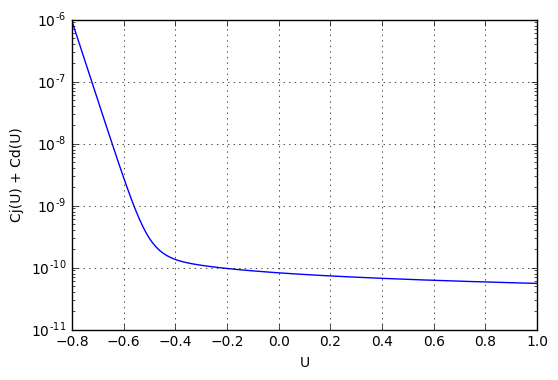

In [5]:
Uv = np.linspace(-0.8, 1.0, 251)
Cv = [dcap(U, Ut, phi, gamma, Cf, Cr, fs) for U in Uv]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel("U")
ax.set_ylabel("Cj(U) + Cd(U)")
ax.plot(Uv, Cv)
ax.grid()
plt.show()

Lisaks ka difusioonivool:

In [6]:
def dcur(U, Ut, If):
    return If * (1 - np.exp(-U / Ut))

Samuti joonistame ka voolu:

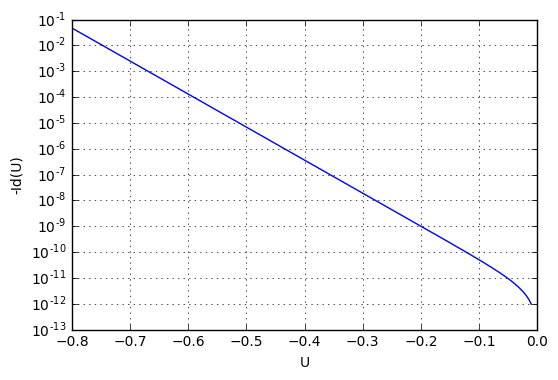

In [7]:
Uv = np.linspace(-0.8, -0.01, 251)
Iv = [-dcur(U, Ut, If) for U in Uv]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel("U")
ax.set_ylabel("-Id(U)")
ax.plot(Uv, Iv)
ax.grid()
plt.show()

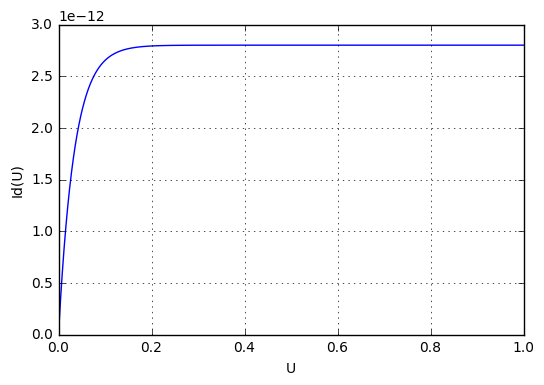

In [8]:
Uv = np.linspace(0.0, 1.0, 251)
Iv = [dcur(U, Ut, If) for U in Uv]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel("U")
ax.set_ylabel("Id(U)")
ax.plot(Uv, Iv)
ax.grid()
plt.show()

Generaatori amplituudiga võib katsetada - siin on mõned huvitavad väärtused:

In [22]:
Usvals = [0.5, 0.7, 1.0, 2.0, 3.0, 3.3, 3.5, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]
Us = Usvals[8]

Lõpuks defineerime süsteemi dünaamikat:

In [10]:
def osc(y, t, res, ind, Us, Ut, phi, gamma, If, Cf, Cr, fs, omega):
    U, I = y
    Cd = dcap(U, Ut, phi, gamma, Cf, Cr, fs)
    Id = dcur(U, Ut, If)
    dydt = [(I - Id) / Cd, (Us * np.cos(omega * t) - U - res * I) / ind]
    return dydt

## Liikumisvõrrandite lahendamine

Liikumisvõrrandite lahendamiseks on meil lisaks dünaamikale ka algtingimusi vaja. Siin eeldame et alguses, $t = 0$, kehtib $U(0) = 0$ ja $I(0) = 0$.

In [11]:
y0 = [0.0, 0.0]

Järgmisena valime, millises ajavahemikus me soovime võrrandeid lahendada. Vahemik on valitud nii, et kui võnkumisi konverteeritakse helifailiks, siis helifaili kestus on 12s. Lisaks defineerime audio diskreetimissagedus (*sampling rate*), tavaline valik on 44100 (heli CD). Integreerimissammu valime selliseks, et jagame generaatori perioodi 100 sammuks. Sellest järeldub, et heli sagedus on 441Hz.

In [12]:
smprt = 44100
slow = omega / 882.0 / np.pi
duration = 12.0

Nende konstantidega defineerime ajavahemiku $T = [t_0, t_1]$, milles liikumisvõrrandeid lahendada.

In [13]:
time = duration / slow
samples = duration * smprt + 1
nsmp = (int)(1e-4 * smprt * slow)
t = np.linspace(0, time, samples)

Lõpuks kasutame SymPy funktsiooni odeint võrrandite lahendamiseks.

In [23]:
sol = odeint(osc, y0, t, args = (res, ind, Us, Ut, phi, gamma, If, Cf, Cr, fs, omega))
Usol = sol[:, 0]
Isol = sol[:, 1]

## Joonis: pinge ja vool sõltuvalt ajast

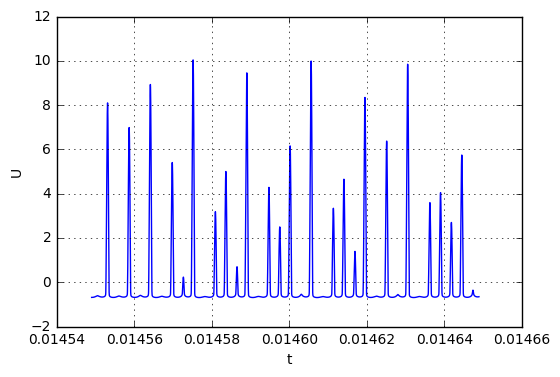

In [24]:
plt.plot(t[-nsmp:], Usol[-nsmp:])
plt.xlabel("t")
plt.ylabel("U")
plt.grid()
plt.show()

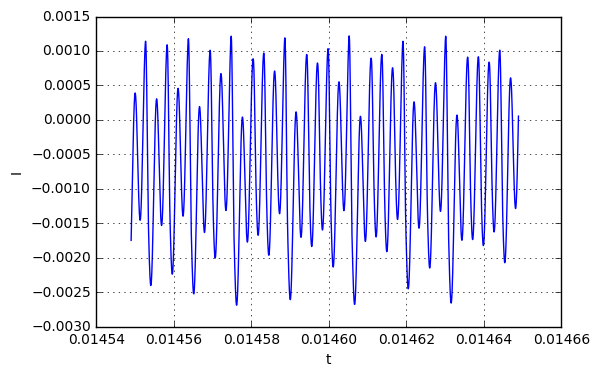

In [26]:
plt.plot(t[-nsmp:], Isol[-nsmp:])
plt.xlabel("t")
plt.ylabel("I")
plt.grid()
plt.show()

## Joonis: pinge vs vool

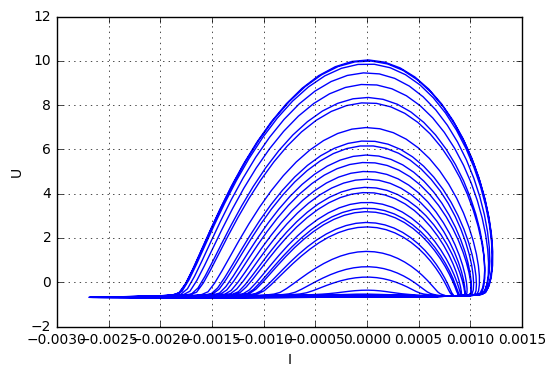

In [27]:
plt.plot(Isol[-nsmp:], Usol[-nsmp:])
plt.xlabel("I")
plt.ylabel("U")
plt.grid()
plt.show()

## Liikumise konverteerimine heliks

In [18]:
wfm = np.interp(Usol, [min(Usol), max(Usol)], [-1 * 2**15, 2**15 - 1]).astype(np.int16)
Audio(data=wfm, rate=smprt)

In [19]:
wfm = np.interp(Isol, [min(Isol), max(Isol)], [-1 * 2**15, 2**15 - 1]).astype(np.int16)
Audio(data=wfm, rate=smprt)

## Poincaré lõige

Järgmisena joonistame Poincaré lõiget. Selleks jätame siirdeseisundi (näiteks 10000 sammu) simulatsiooni alguses ära, ja joonistame ainult seda osa, kui võnkumine on juba lähenenud stabiilsele olekule. Siis joonistame ainult ühe punkti igast generaatori perioodist, ehk igat 100. sammu. Poincaré lõige sõltub generaatori faasist.

In [20]:
def poinc(phas):
    Uval = Usol[10000 + phas::100]
    Ival = Isol[10000 + phas::100]
    plt.plot(Ival, Uval, 'b.', markersize=5)
    plt.xlabel("I")
    plt.ylabel("U")
    plt.grid()
    plt.show()

Kuna me jagasime generaatori perioodi 100 sammuks, varieerub faas 0 ja 99 vahel.

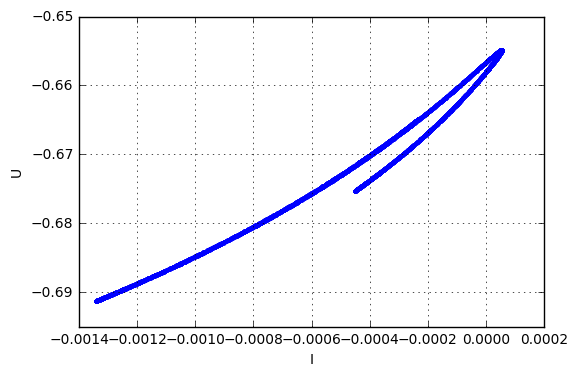

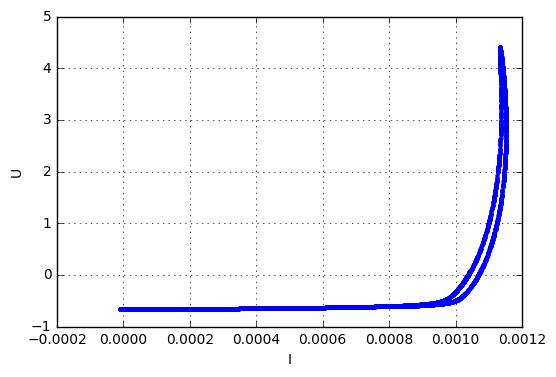

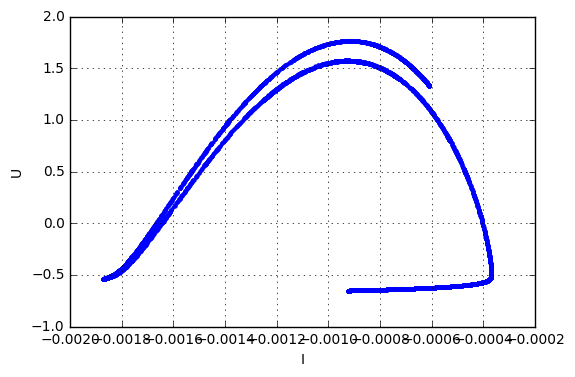

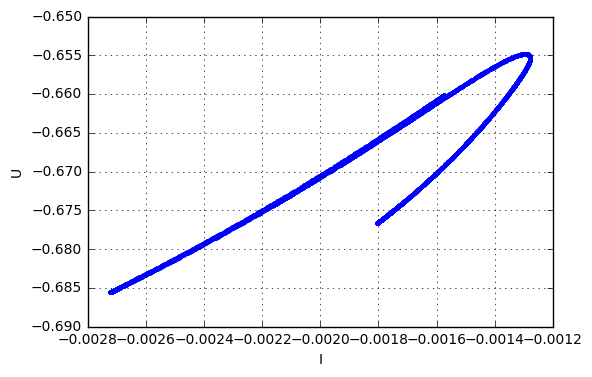

In [25]:
poinc(0)
poinc(25)
poinc(50)
poinc(75)

Kui trajektoor on perioodiline, on punktide arv lõplik ja joonis näitab diskreetseid punkte. Kui trajektoor on mitteperioodiline, tekib igas generaatoriperioodis uus punkt, ja joonis on mittediskreetne.